In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [2]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.1/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

In [3]:
!pip install ultralytics
!pip install roboflow

!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow


rf = Roboflow(api_key="NEOzgX48gZapMxWR9lbq")
project = rf.workspace("mohamed-traore-2ekkp").project("taco-trash-annotations-in-context")
version = project.version(16)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TACO:-Trash-Annotations-in-Context-Dataset-16 in yolov11:: 100%|██████████| 7204/7204 [00:01<00:00, 4458.53it/s]


/content


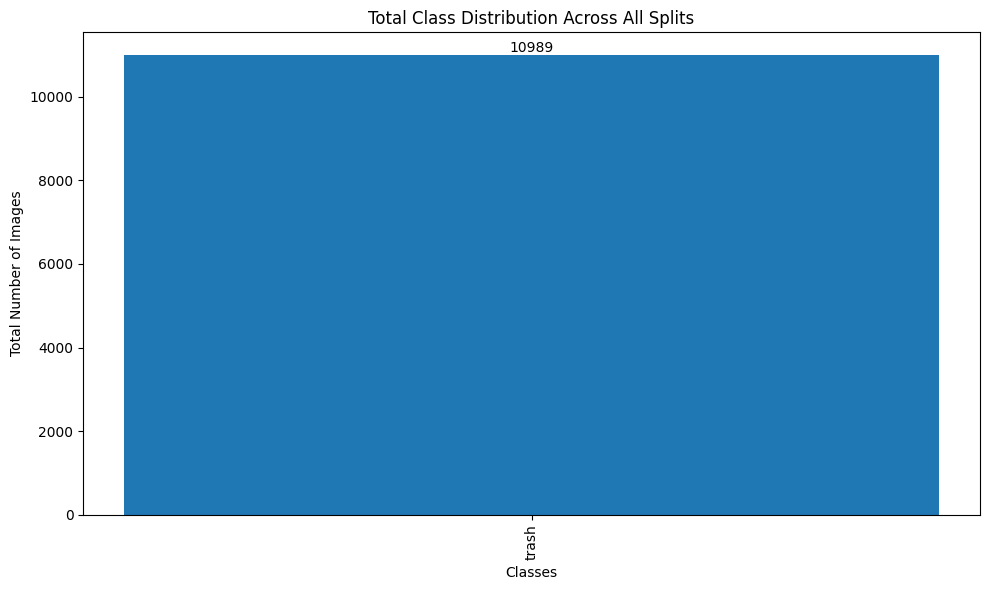

In [4]:
import os
import matplotlib.pyplot as plt
import yaml

%cd {HOME}

# Define paths for the dataset
dataset_splits = ["train", "valid", "test"]
class_counts_per_split = {}

# Count occurrences of each class in all splits
for split in dataset_splits:
    label_folder = os.path.join(dataset.location, split, "labels")
    class_counts = {}
    for filename in os.listdir(label_folder):
        with open(os.path.join(label_folder, filename), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                if class_id not in class_counts:
                    class_counts[class_id] = 0
                class_counts[class_id] += 1
    class_counts_per_split[split] = class_counts

# Load class names from data.yaml
with open(f'{dataset.location}/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
class_names = data['names']

# Aggregate class counts across all splits
total_class_counts = {class_id: 0 for class_id in class_counts_per_split["train"].keys()}
for split in dataset_splits:
    for class_id, count in class_counts_per_split[split].items():
        total_class_counts[class_id] += count

# Create a bar chart to show the total distribution of classes across all splits
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(total_class_counts)), list(total_class_counts.values()))
plt.xticks(range(len(total_class_counts)), [class_names[i] for i in total_class_counts.keys()], rotation=90)
plt.xlabel("Classes")
plt.ylabel("Total Number of Images")
plt.title("Total Class Distribution Across All Splits")

# Add text annotations on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()


/content
Class               Train          Valid          Test           
-----------------------------------------------------------------
trash               9406           1014           569            



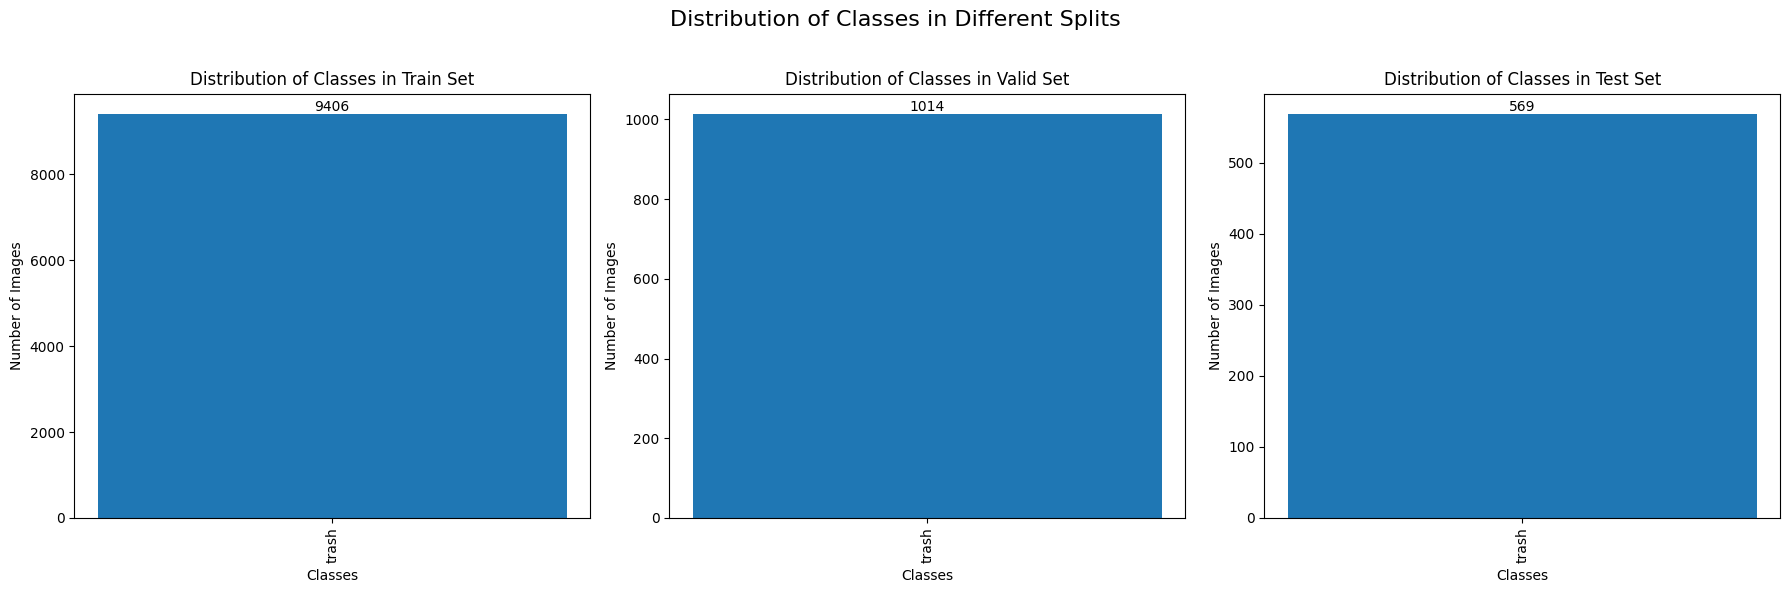

In [5]:
import os
import matplotlib.pyplot as plt
import yaml
from collections import OrderedDict
import matplotlib.image as mpimg
import numpy as np

%cd {HOME}

def count_classes(folder):
    """Counts the occurrences of each class in a dataset folder."""
    label_folder = os.path.join(folder, "labels")
    class_counts = {}
    for filename in os.listdir(label_folder):
        with open(os.path.join(label_folder, filename), 'r') as f:
            for line in f:
                class_id = int(line.split()[0])
                if class_id not in class_counts:
                    class_counts[class_id] = 0
                class_counts[class_id] += 1
    return class_counts

# Assuming 'dataset.location' is defined and holds the base directory of the dataset
dataset_splits = ["train", "valid", "test"]
class_counts_per_split = {}

for split in dataset_splits:
    folder = os.path.join(dataset.location, split)
    class_counts_per_split[split] = count_classes(folder)

# Load class names from data.yaml
with open(f'{dataset.location}/data.yaml', 'r') as f:
    data = yaml.safe_load(f)
class_names = data['names']

# Print class counts side by side
# Create an ordered set of all classes in all splits to have a common order and make sure all classes are displayed
all_classes = OrderedDict()
for split in dataset_splits:
    for class_id in class_counts_per_split[split].keys():
        if class_id not in all_classes:
             all_classes[class_id] = None

# Print header with split names
header = "Class".ljust(20)
for split in dataset_splits:
    header += f"{split.capitalize()}".ljust(15)
print(header)
print("-" * len(header))

for class_id in all_classes.keys():
    line = class_names[class_id].ljust(20)
    for split in dataset_splits:
        count = class_counts_per_split[split].get(class_id, 0)
        line += f"{count}".ljust(15)
    print(line)
print()

# Create bar charts for each split side by side
fig_bars, axes_bars = plt.subplots(1, len(dataset_splits), figsize=(6 * len(dataset_splits), 6))
fig_bars.suptitle("Distribution of Classes in Different Splits\n", fontsize=16)

for i, split in enumerate(dataset_splits):
    class_counts = class_counts_per_split[split]
    ax = axes_bars[i] if len(dataset_splits) > 1 else axes_bars

    # Use all_classes keys to order the bars
    ordered_class_ids = list(all_classes.keys())
    ordered_counts = [class_counts.get(class_id, 0) for class_id in ordered_class_ids]

    bars = ax.bar(range(len(ordered_class_ids)), ordered_counts)
    ax.set_xticks(range(len(ordered_class_ids)))
    ax.set_xticklabels([class_names[i] for i in ordered_class_ids], rotation=90)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Number of Images")
    ax.set_title(f"Distribution of Classes in {split.capitalize()} Set")

    # Add text annotations on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()
plt.show()

## Custom Training

In [6]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

/content
100% 5.35M/5.35M [00:00<00:00, 420MB/s]
New https://pypi.org/project/ultralytics/8.3.178 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [7]:
!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1970.jpg
confusion_matrix_normalized.png			    train_batch1971.jpg
confusion_matrix.png				    train_batch1972.jpg
events.out.tfevents.1755033052.08e0f9f525dd.1341.0  train_batch1.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


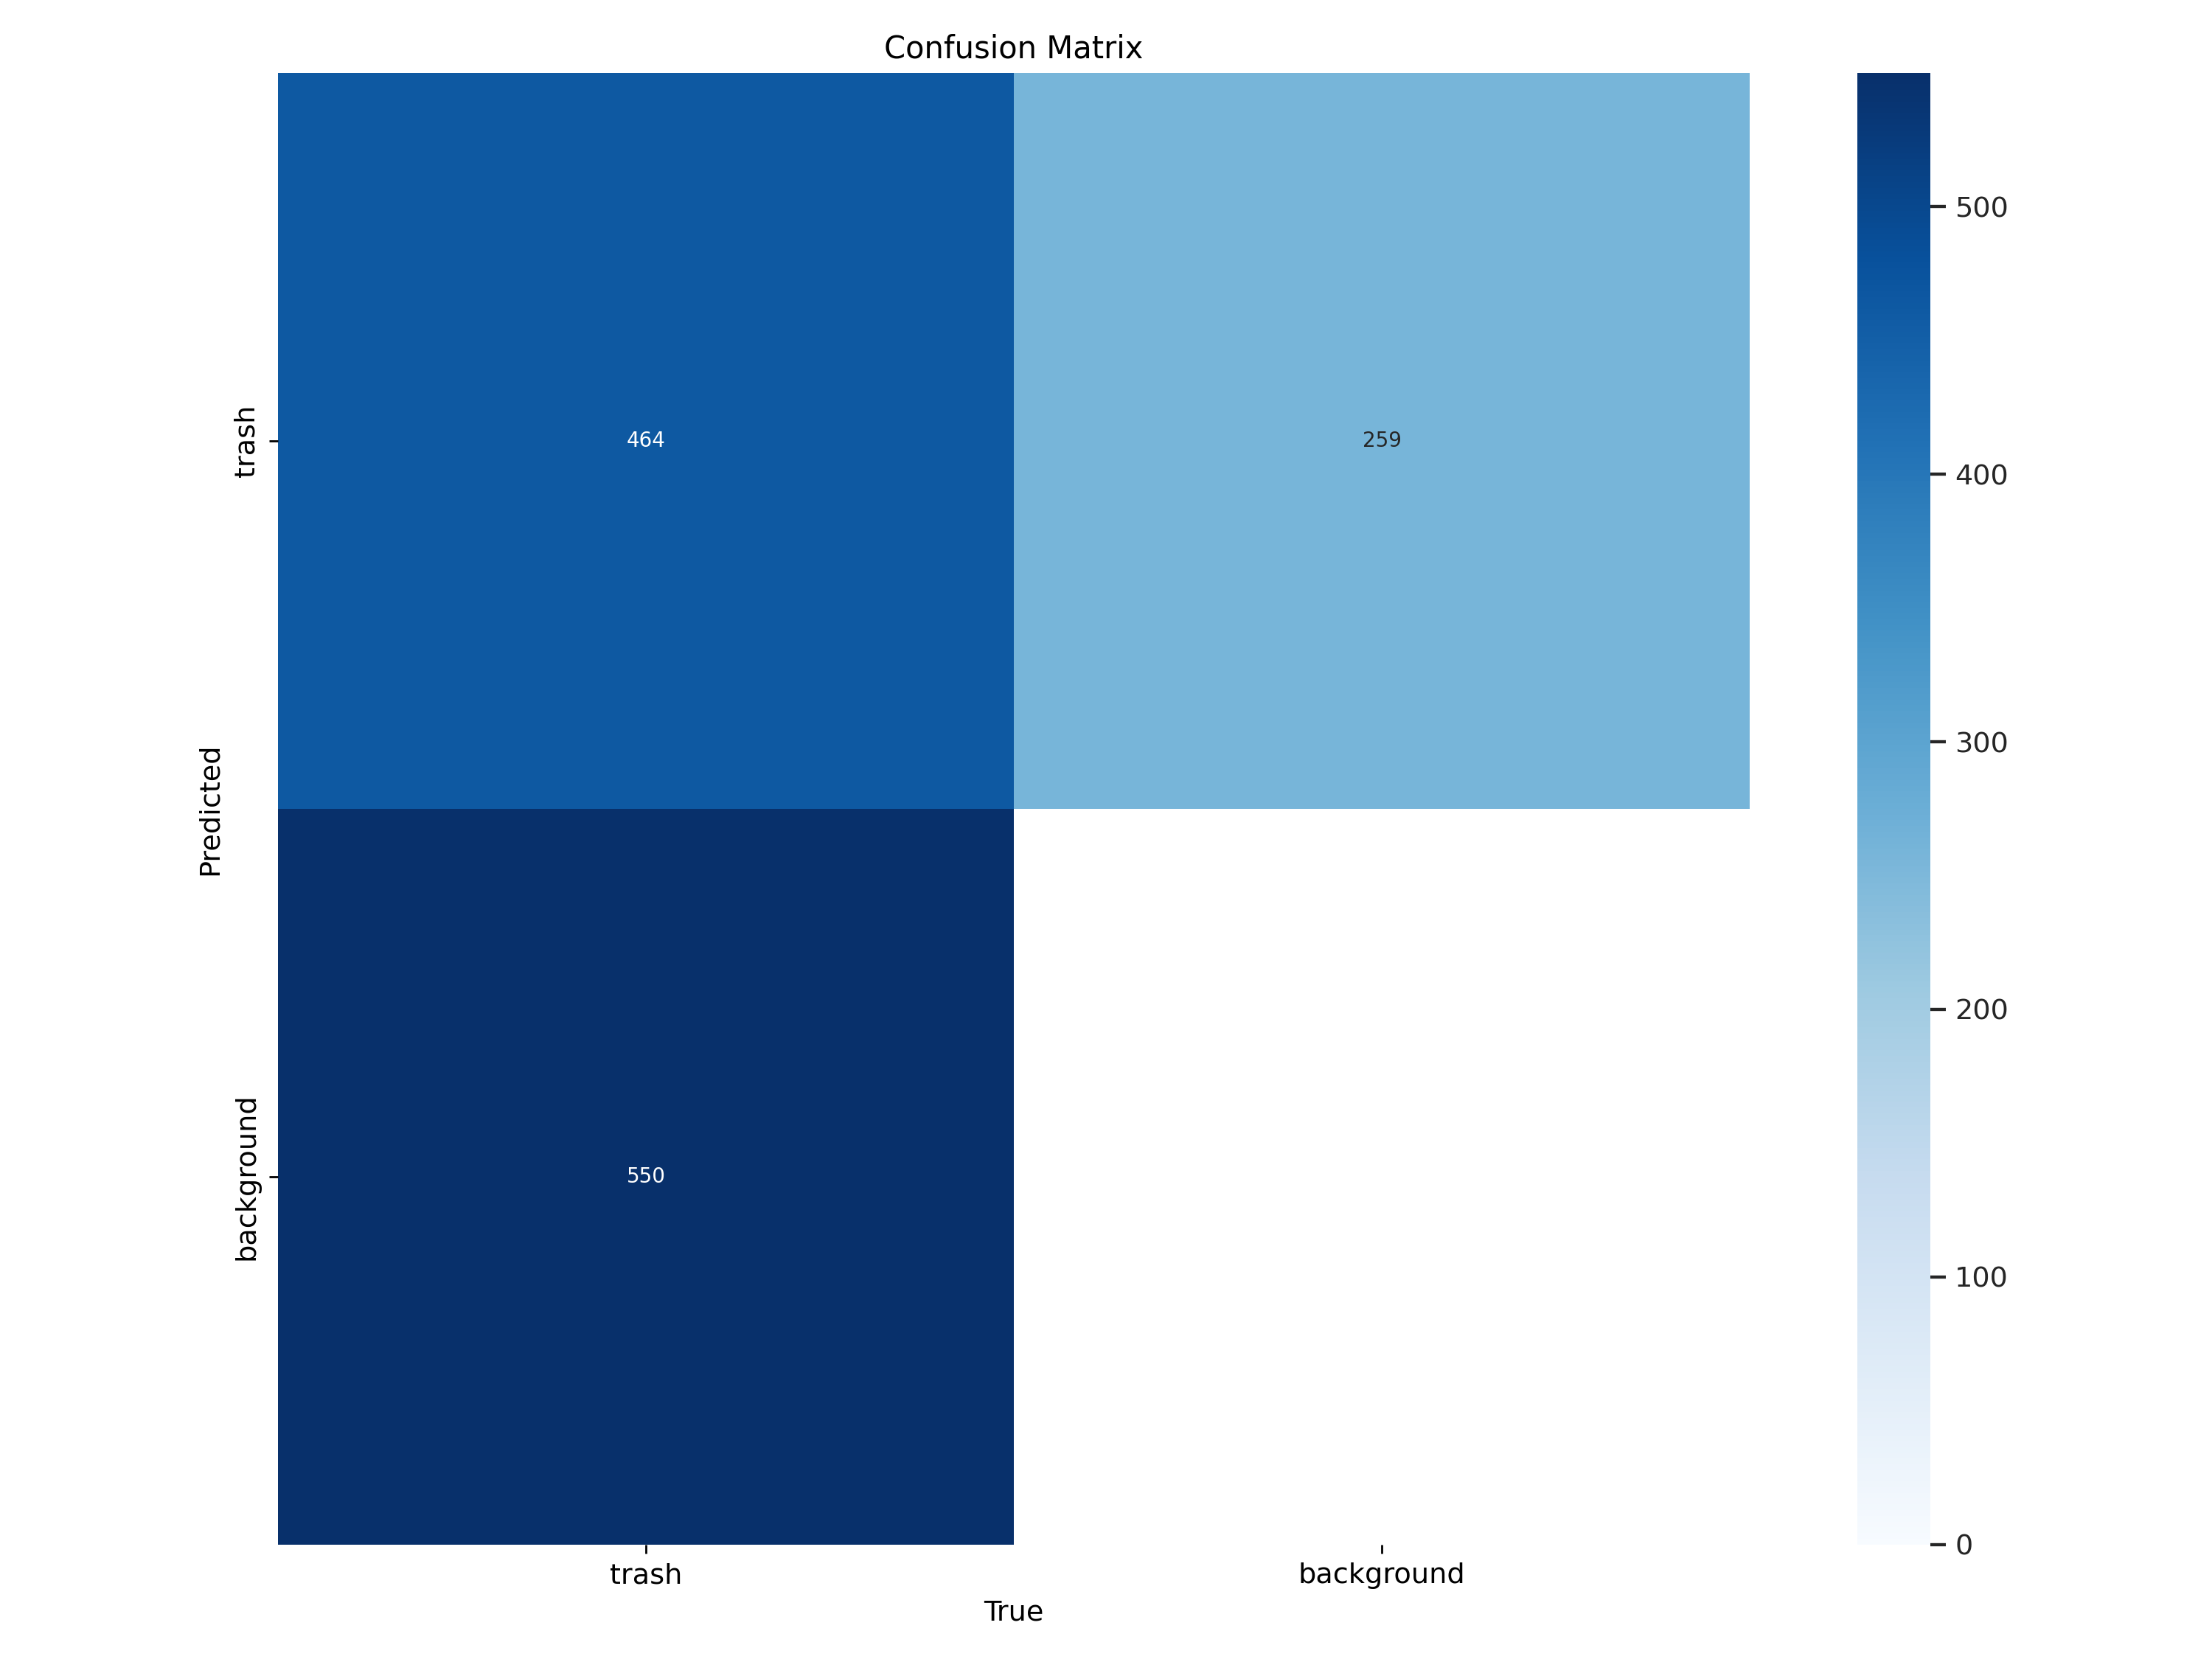

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

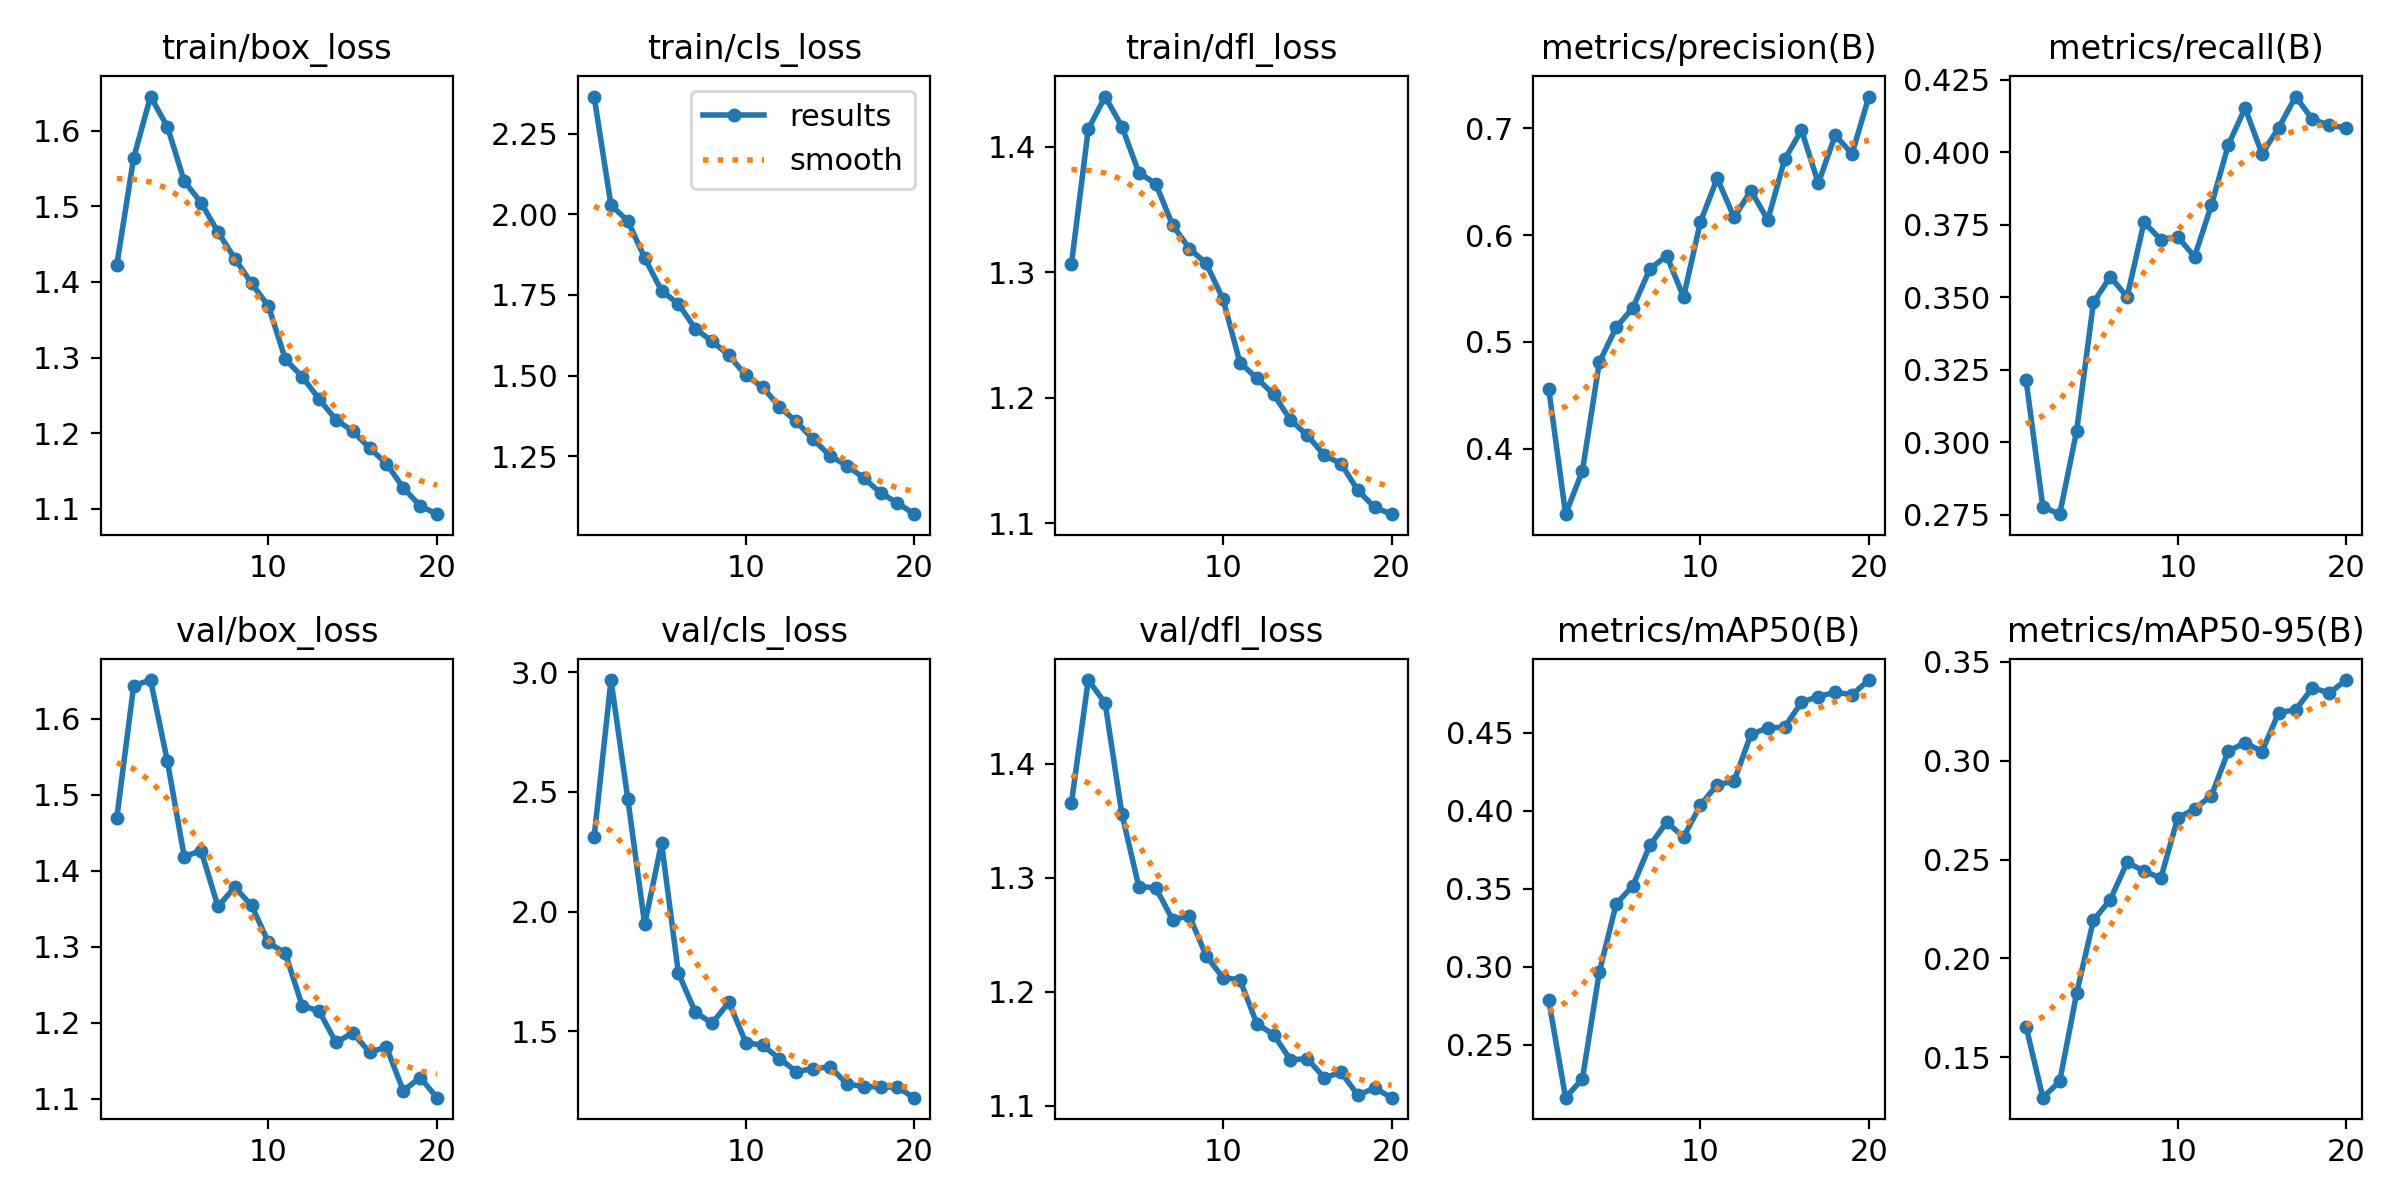

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

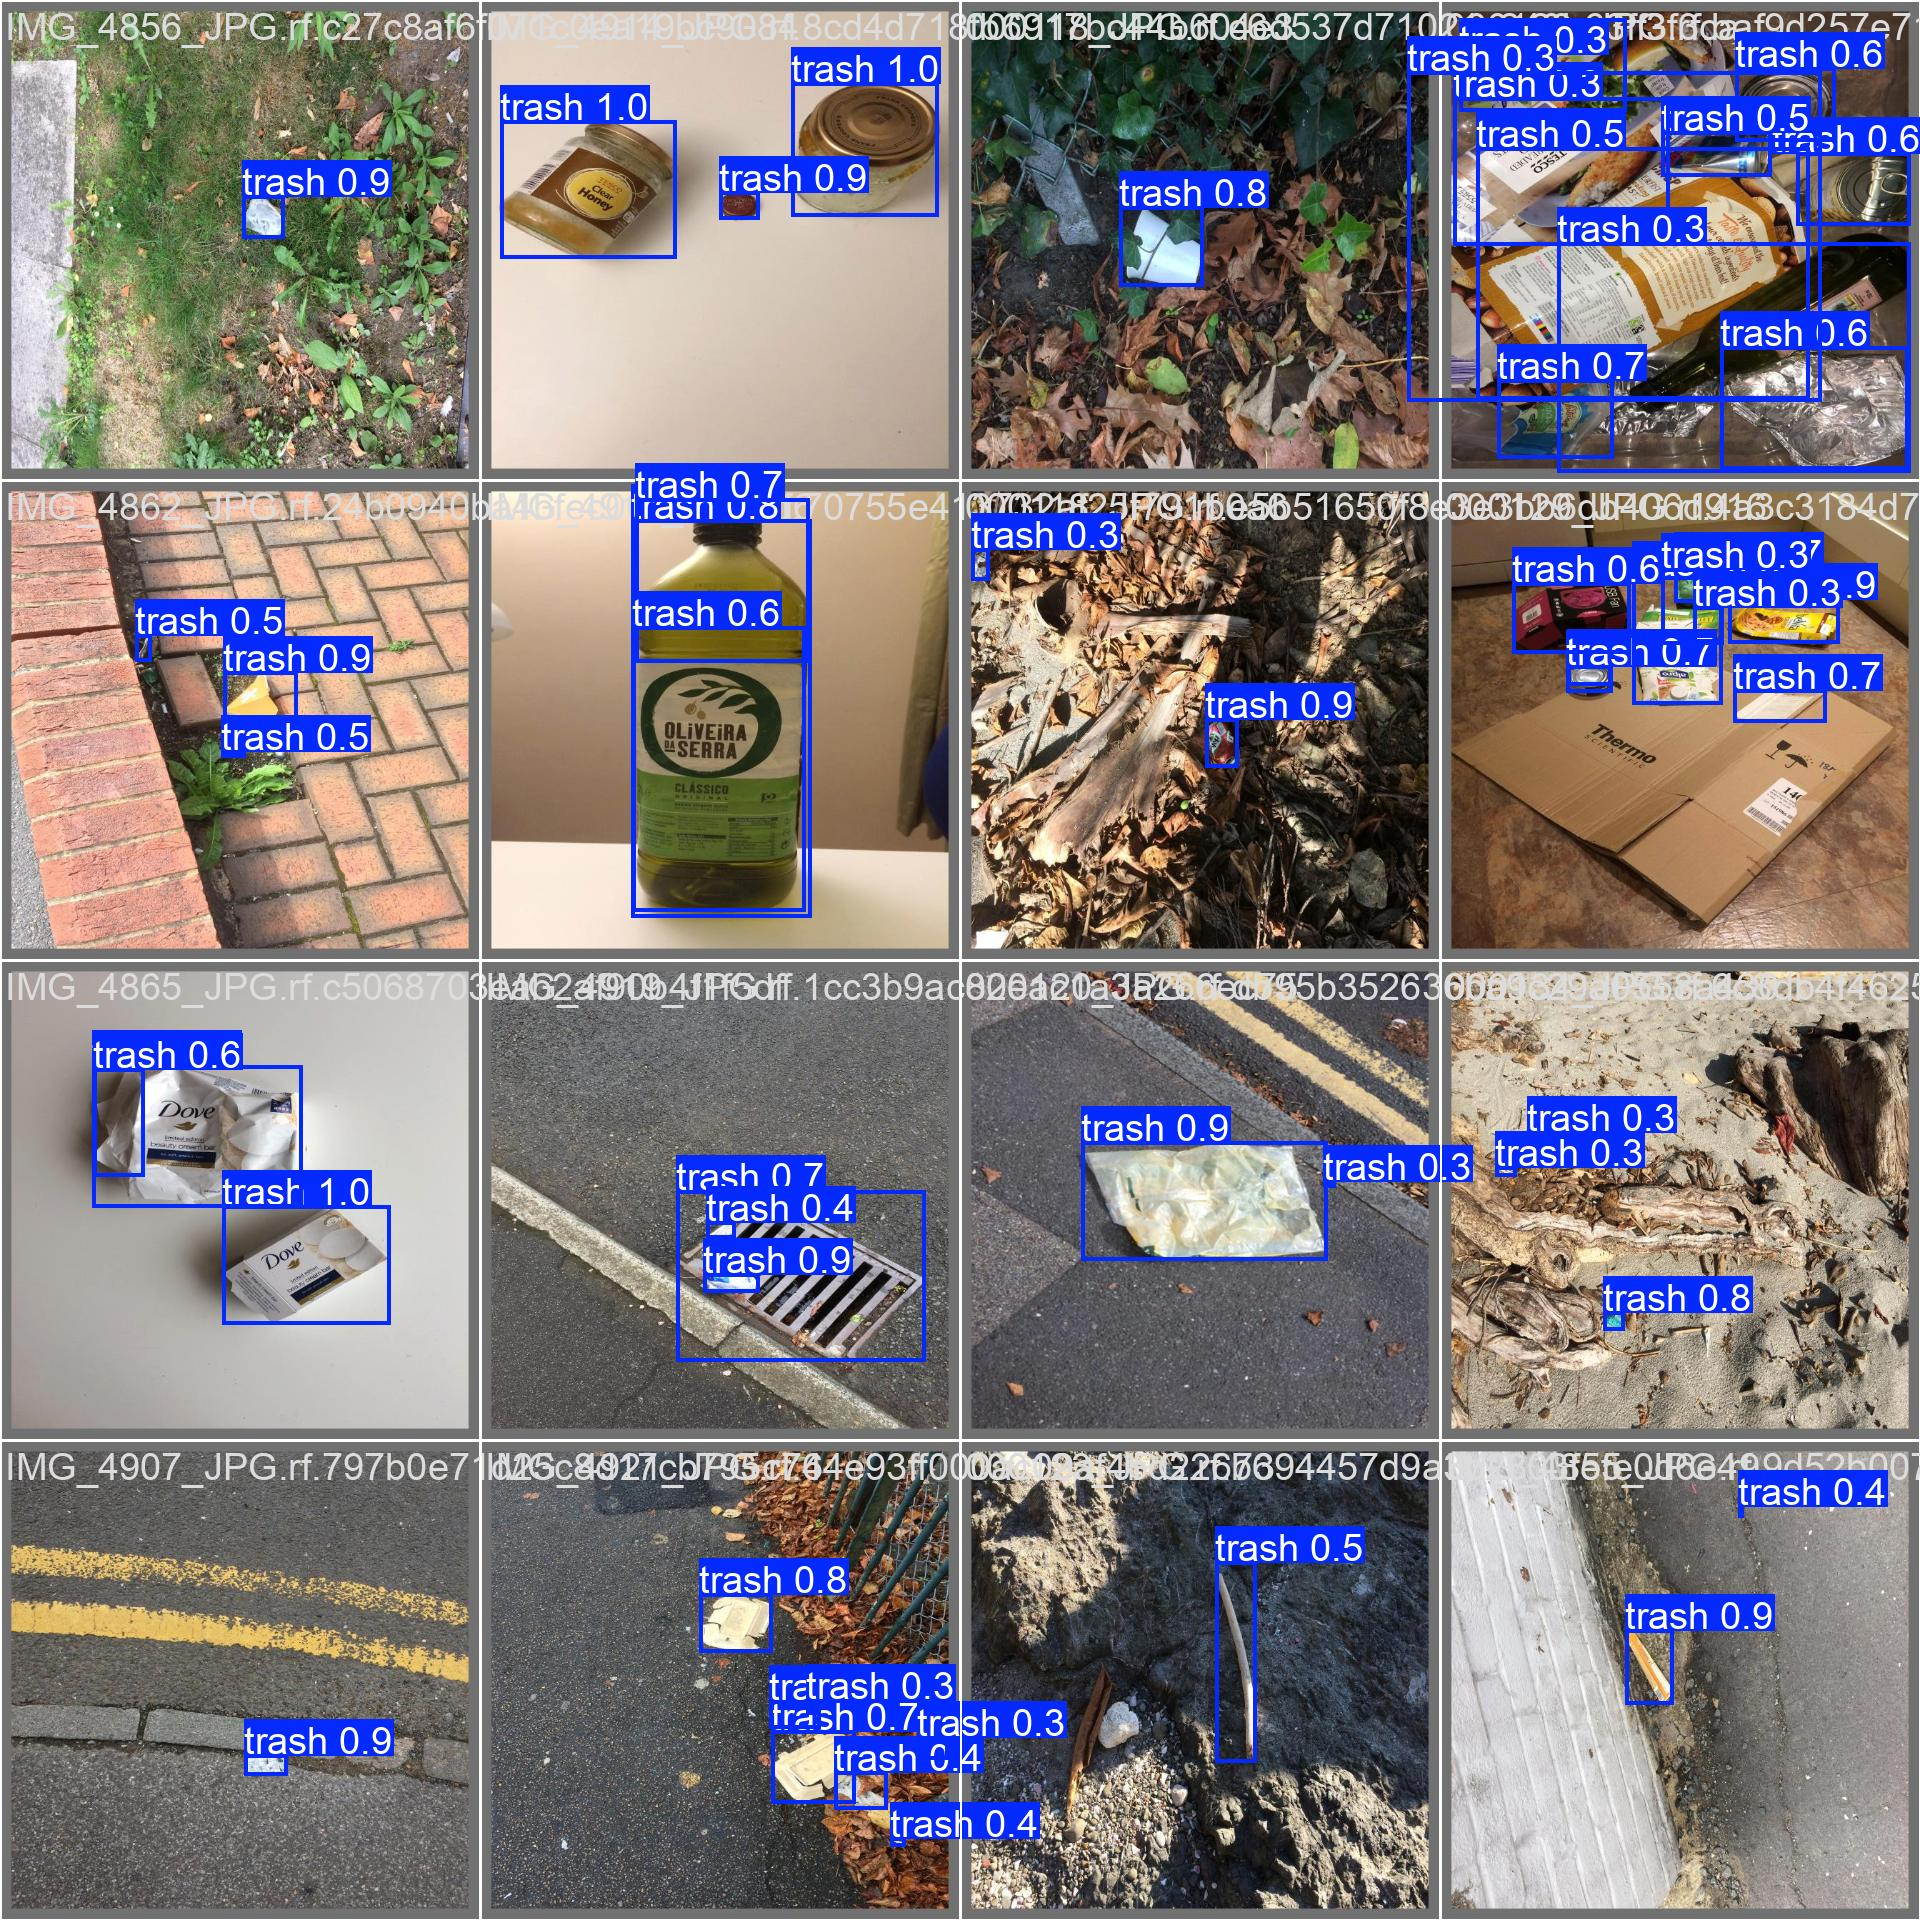

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=1000)

## Validate fine-tuned model

In [11]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/valid/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100% 299/299 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 19/19 [00:05<00:00,  3.61it/s]
                   all        299       1014      0.729      0.407      0.483      0.341
Speed: 1.6ms preprocess, 5.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [12]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

image 1/151 /content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/test/images/000001_JPG.rf.1cebaa7292e525c3616c1e6626718cee.jpg: 640x640 6 trashs, 12.6ms
image 2/151 /content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/test/images/000002_jpg.rf.f0c70585c8465d2c8a31110463f678ce.jpg: 640x640 1 trash, 9.6ms
image 3/151 /content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/test/images/000004_jpg.rf.f220eaab0f36226385a34eb0708f9936.jpg: 640x640 1 trash, 8.3ms
image 4/151 /content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/test/images/000005_jpg.rf.28c2d4c5813f54368ede1bfa04bc3ad1.jpg: 640x640 2 trashs, 8.0ms
image 5/151 /content/datasets/TACO:-Trash-Annotations-in-Context-Dataset-16/test/images/000006_JPG.rf.a75a06bbee739f71071fe6e17c41aebe.jpg: 640x640 4 trashs, 8.4ms
image 6/151 /co

**NOTE:** Let's take a look at few results.

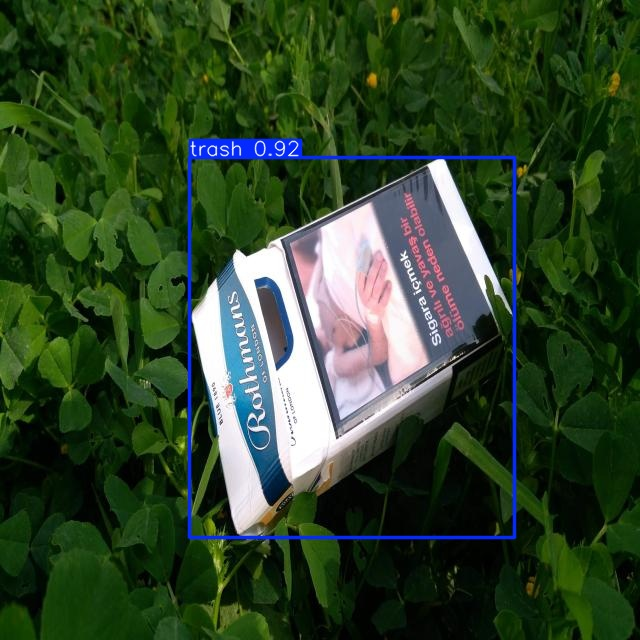

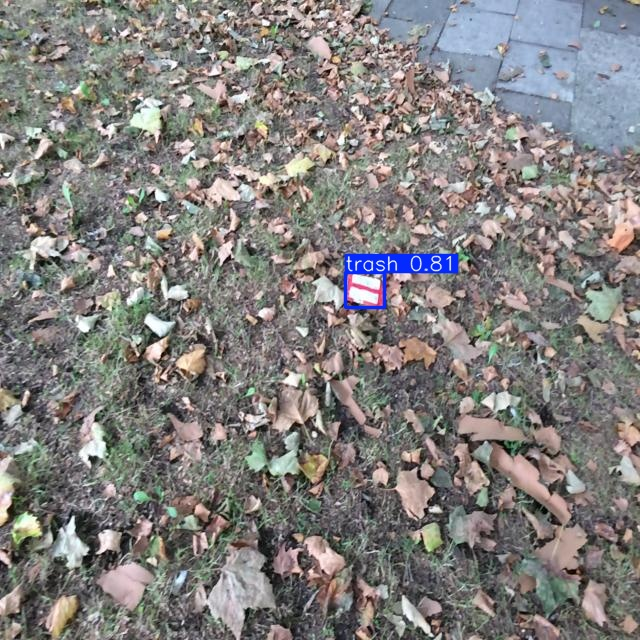

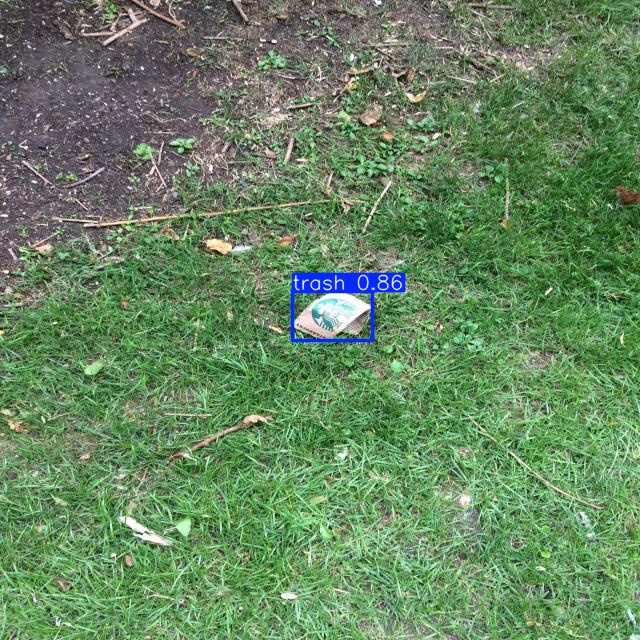

In [13]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

⚠️ Download failure, retrying 1/3 https://i0.wp.com/travel67.com/wp-content/uploads/2018/06/img_5443.jpg...
######################################################################## 100.0%
image 1/1 /content/img_5443.jpg: 480x640 9 trashs, 46.8ms
Speed: 4.7ms preprocess, 46.8ms inference, 149.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

Found https://i0.wp.com/travel67.com/wp-content/uploads/2018/06/img_5443.jpg locally at img_5443.jpg
image 1/1 /content/img_5443.jpg: 480x640 9 trashs, 46.7ms
Speed: 4.5ms preprocess, 46.7ms inference, 152.0ms postprocess per 

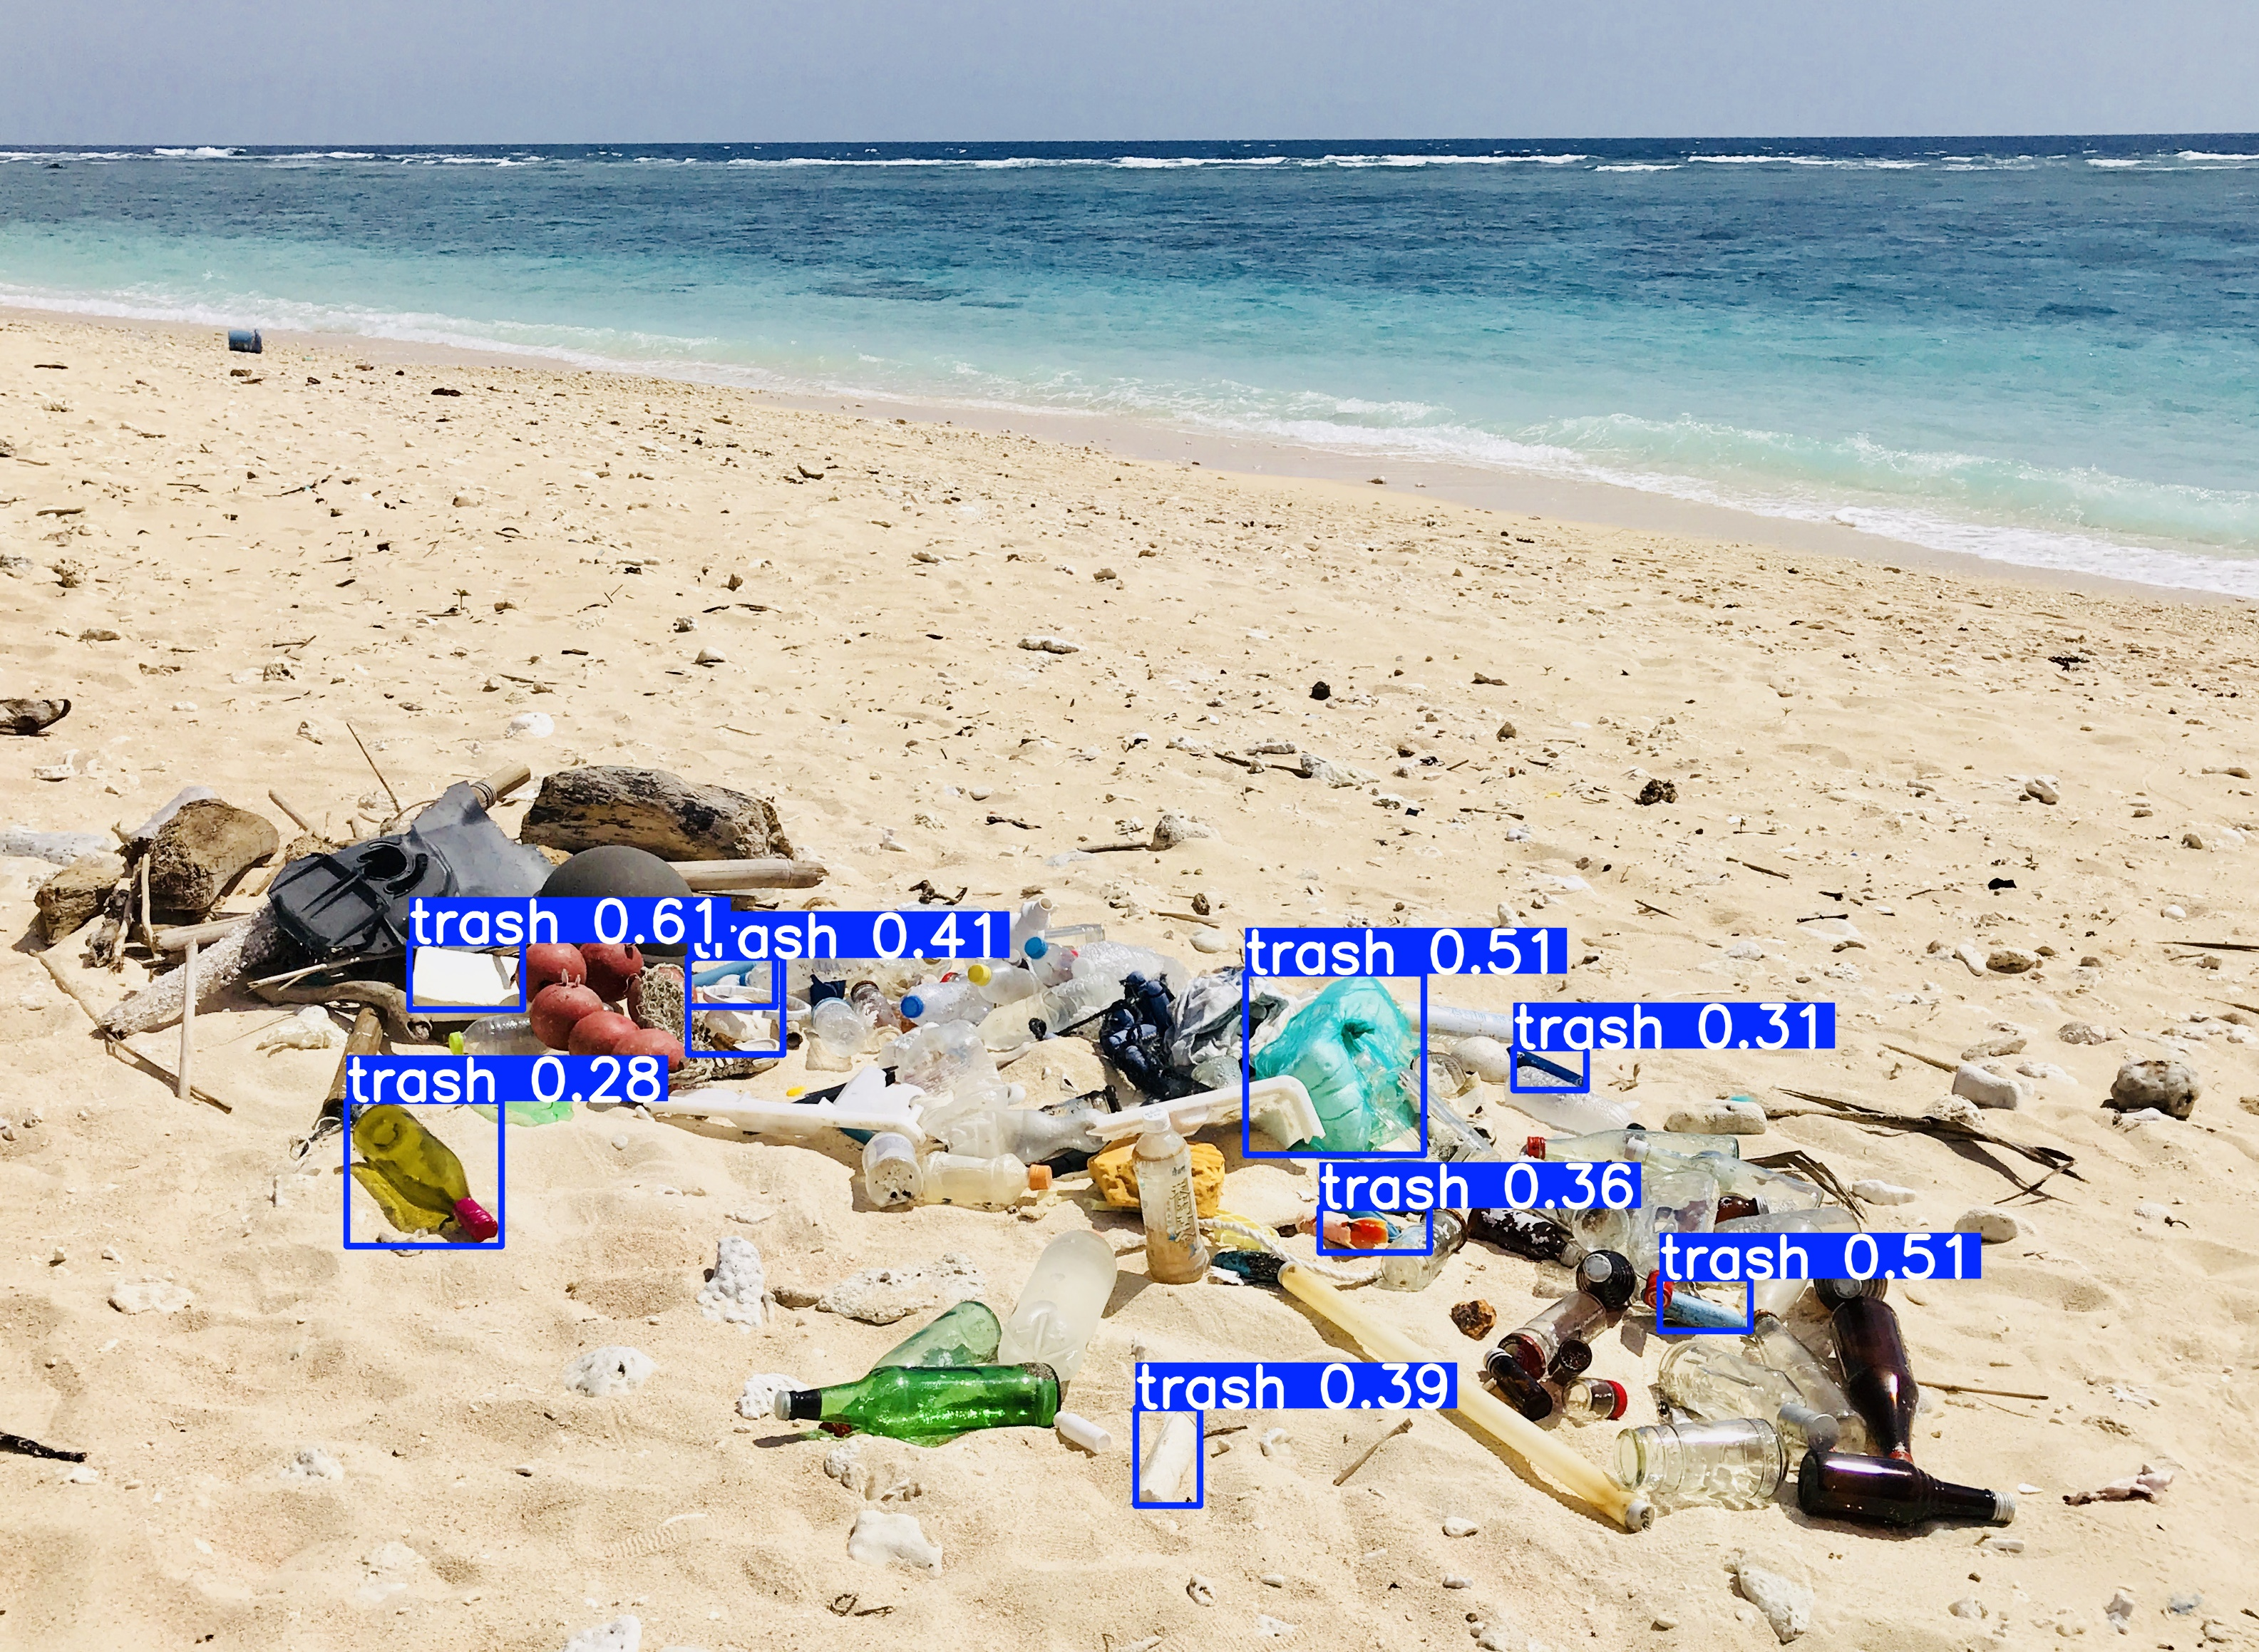

In [14]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source='https://i0.wp.com/travel67.com/wp-content/uploads/2018/06/img_5443.jpg' save=True

import glob
import os
from IPython.display import Image as IPyImage, display

# Get the latest prediction folder
latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)

!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source='https://i0.wp.com/travel67.com/wp-content/uploads/2018/06/img_5443.jpg' save=True

import glob
import os
from IPython.display import Image as IPyImage, display

# Get the latest prediction folder
latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)

# Display the image with predictions
for img in glob.glob(f'{latest_folder}/*.jpg'):
    display(IPyImage(filename=img, width=600))

In [15]:
import time
from google.colab import files

# Step 1: Define path to the model weights
# Corrected path: Assuming training output is in 'runs/detect/train'
model_weights_path = 'runs/detect/train/weights/best.pt'
# If your training output is in 'runs/detect/train2', then keep the original path

# Step 2: Start the timer
start_time = time.time()

# Download the model weights
files.download(model_weights_path)

# Step 3: Calculate the time taken to download
end_time = time.time()
download_time = end_time - start_time

# Print the download time
print(f"Model weights downloaded successfully in {download_time:.2f} seconds.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model weights downloaded successfully in 0.00 seconds.
